In [78]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch

from find_transform import aligned_coords2line
from refine_transform import match_two_aligned_fragments

from tqdm import tqdm
from utils import *
from refine_transform import *
from find_transform import *
from shape_align import new_pairwise_alignment
from skimage.color import rgb2lab, lab2rgb

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

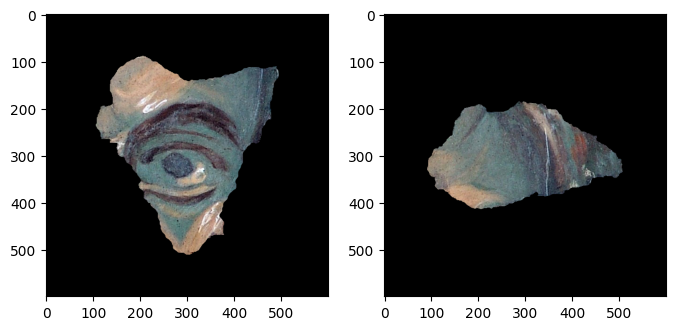

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [61]:
frags = [
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/8'), 200),
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200),
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200),
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/12'), 200),
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/13'), 200)
]


In [62]:
descriptors, alignments = new_pairwise_alignment(palette,frags, blocks_num=3)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:10<00:00, 233.32it/s]


9
1
Aligning fragments 0 and 2:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:03<00:00, 732.66it/s]


9
1
Aligning fragments 0 and 3:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:04<00:00, 531.22it/s]


9
4
Aligning fragments 1 and 2:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:02<00:00, 749.89it/s]


8
1
Aligning fragments 1 and 3:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:03<00:00, 524.16it/s]


9
1
Aligning fragments 2 and 3:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 519.61it/s]


9
2


In [76]:
l, r = 0, 1

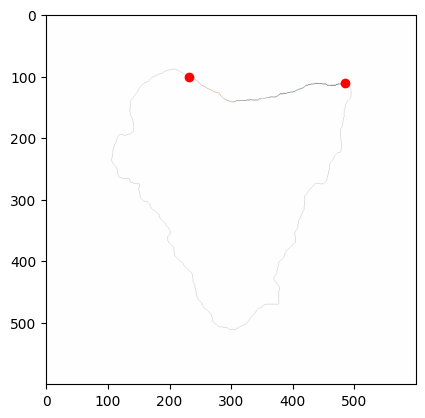

In [79]:
# common_edge = np.ones((frags[l].fragment.shape[0] * 2, frags[l].fragment.shape[1] * 2, 3))
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignments[(l, r)][align_index].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
#     print(point)
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

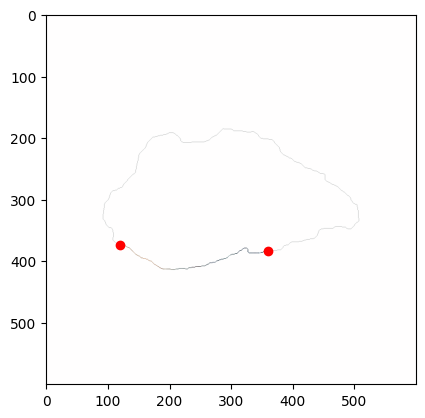

In [80]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignments[(l, r)][align_index].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [69]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)
conv = mobilenet.features[0][0]
conv.stride = (1, 1)
feature_extractor = conv
feature_extractor.requires_grad_(False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [120]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
#     img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:,pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]

    if len(resized_mask2.shape) == 2:
        resized_mask2 = resized_mask2[:, :, None]
    if len(resized_mask1.shape) == 2:
        resized_mask1 = resized_mask1[:, :, None]

    padded_mask2 = np.pad(resized_mask2, ((pad, pad), (pad, pad), (0, 0)))
    shifted_mask2 = padded_mask2[pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
    
    where = np.logical_and(resized_mask1, shifted_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    return features_cross_corr
#     cross_corr = (img_cross_corr + features_cross_corr) / 2
#     return cross_corr

def match_two_aligned_fragments(frag1, frag2, list_of_initial_params, subcurves1, subcurves2, feature_extractor, beta=0.5, pad_size=200, verbose=1):
    """
    list_of_initial_params: list of (angle, x, y)
    frag1, frag2: Fragments
    subcurves1, subcurves2: common subcurves from frag1 and frag2, each corresponds to initial_params
    """
#     padded_frag1 = pad_fragment(frag1, pad_size) # TODO: fix: pad_fragment_to_size
#     padded_frag2 = pad_fragment(frag2, pad_size)
    padded_frag1 = pad_fragment_to_size(frag1, pad_size)
    padded_frag2 = pad_fragment_to_size(frag2, pad_size)
    
    tensor1 = torch.tensor(padded_frag1.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
    features1 = feature_extractor(tensor1)
    features1 = features1.squeeze(0).detach().numpy()
    
#     resized_mask1 = skimage.transform.resize(
#         padded_frag1.extended_mask,
#         (padded_frag1.fragment.shape[0] // 2, padded_frag1.fragment.shape[1] // 2)
#     )
    
    global_res = []
    
    for params_index, initial_params in enumerate(list_of_initial_params):
        theta, x_initial, y_initial = initial_params
        subcurve1 = subcurves1[params_index]
        subcurve2 = subcurves2[params_index]
        
        shifts = [(x, y) for x in range(x_initial - 30, x_initial + 31, 6) for y in range(y_initial - 30, y_initial + 31, 6)]
        for phi in np.arange(theta - 15, theta + 16, 5):
            if verbose == 1:
                print(f"phi = {phi}, params_index = {params_index}")
            rot_frag2 = rotate_fragment(padded_frag2, phi)
            tensor2 = torch.tensor(rot_frag2.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
            features2 = feature_extractor(tensor2)
            features2 = features2.squeeze(0).detach().numpy()
#             resized_mask2 = skimage.transform.resize(
#                 rot_frag2.extended_mask, 
#                 (rot_frag2.fragment.shape[0] // 2, rot_frag2.fragment.shape[1] // 2)
#             )

            good_shifts = []
            for (x, y) in tqdm(shifts) if verbose == 1 else shifts:
                transformed2 = shift_fragment(rot_frag2, x, y)
                if check_possibility_of_translation(padded_frag1, transformed2):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                    prob = geom_score
#                     print(prob)
                    if prob > 0.5:
#                         content_score = compute_new_content_score(
#                             padded_frag1, transformed2,
#                             features1, features2,
#                             resized_mask1, resized_mask2,
#                             (x, y)                        
#                         )
#                         prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)

#                         print(geom_score, content_score, prob)
#                         trans = Translation(x, y, phi, prob)
#                         global_res.append(trans)
                        if prob > 0.5:
                            good_shifts.extend([(x_new, y_new) for x_new in range(x - 2, x + 3, 2) for y_new in range(y - 2, y + 3, 2)])
            for (x, y) in tqdm(good_shifts) if verbose == 1 else good_shifts:
                transformed2 = shift_fragment(rot_frag2, x, y)
                if check_possibility_of_translation(padded_frag1, transformed2):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                    prob = geom_score
#                     print(prob)
                    if prob > 0.5:
                        content_score = compute_new_content_score(
                            padded_frag1, transformed2,
                            features1, features2,
                            padded_frag1.extended_mask, transformed2.extended_mask,
                            (x, y)                        
                        )
                        prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                        trans = Translation(x, y, phi, prob)
                        global_res.append(trans)
            
    filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
    return filtered_res

In [130]:
start_time = time.time()
refined_alignment = {}
for l in range(len(frags) - 2):
    for r in range(l + 1, len(frags) - 2):
        print("Refining transform between {} and {}".format(l, r))
        
        list_of_initial_params = []
        subcurves1 = []
        subcurves2 = []
        for alignment in alignments[(l, r)]:
            line1 = aligned_coords2line(alignment.indices, descriptors[l].edge_coords, left=True)
            line2 = aligned_coords2line(alignment.indices, descriptors[r].edge_coords[::-1], left=False)
            line1 -= frags[l].fragment.shape[0] // 2
            line2 -= frags[r].fragment.shape[0] // 2
            best_transform_params = find_best_transform_ransac(line1, line2)
            print(best_transform_params)
            if best_transform_params is None:
                print("No best transform")
                continue
            cos = best_transform_params[0]
            cos = min(cos, 1)
            cos = max(cos, -1)
            theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]
            list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
            subcurves1.append(line1)
            subcurves2.append(line2)
    
        res = match_two_aligned_fragments(
            pad_fragment_to_size(frags[l], 200),
            pad_fragment_to_size(frags[r], 200),
            list_of_initial_params,
            subcurves1,
            subcurves2,
            feature_extractor,
            verbose=1
        )
        print(len(res))
        if len(res) > 0:
#             res = [tr for tr in res if tr.confidence > 0.5]
            tr = sorted(res, reverse=True, key=lambda val: val.confidence)
            refined_alignment[(l, r)] = tr
print("--- %s seconds ---" % (time.time() - start_time))

Refining transform between 0 and 1
[ 9.44359378e-01  3.10552309e-03  2.62052233e+02 -1.13230822e+02]
phi = -34.202960194992585, params_index = 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 145.01it/s]
0it [00:00, ?it/s]


phi = -29.202960194992585, params_index = 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 140.70it/s]
0it [00:00, ?it/s]


phi = -24.202960194992585, params_index = 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 148.73it/s]
0it [00:00, ?it/s]


phi = -19.202960194992585, params_index = 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 147.81it/s]
0it [00:00, ?it/s]


phi = -14.202960194992585, params_index = 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 144.49it/s]
0it [00:00, ?it/s]


phi = -9.202960194992585, params_index = 0


  0%|                                                                                                                                                                                       | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_608/2928479360.py:28: RuntimeWarning: invalid value encountered in scalar divide
  features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.02it/s]


phi = -4.202960194992585, params_index = 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.48it/s]

2
--- 35.621678829193115 seconds ---


In [131]:
refined_alignment

{(0, 1): [Translation(x=-145, y=256, angle=-9.202960194992585, confidence=nan),
  Translation(x=-131, y=270, angle=-4.202960194992585, confidence=nan)]}

In [123]:
l, r = 0, 1

In [124]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

In [125]:
def blend_fragments(frag1, frag2):
    if frag1.fragment.max() > 1:
        frag1.fragment = frag1.fragment / 255
    if frag2.fragment.max() > 1:
        frag2.fragment = frag2.fragment / 255
    if frag1.extended_frag.max() > 1:
        frag1.extended_frag = frag1.extended_frag / 255
    if frag2.extended_frag.max() > 1:
        frag2.extended_frag = frag2.extended_frag / 255
    if frag1.mask.max() > 1:
        frag1.mask = frag1.mask / 255
    if frag2.mask.max() > 1:
        frag2.mask = frag2.mask / 255
    if frag1.extended_mask.max() > 1:
        frag1.extended_mask = frag1.extended_mask / 255
    if frag2.extended_mask.max() > 1:
        frag2.extended_mask = frag2.extended_mask / 255
    return Fragment(
        (frag1.fragment * 1.0 + frag2.fragment * 1.0) / 2,
        (frag1.extended_frag * 1.0 + frag2.extended_frag * 1.0) / 2,
        (frag1.mask * 1.0 + frag2.mask * 1.0) / 2,
        (frag1.extended_mask * 1.0 + frag2.extended_mask * 1.0) / 2,
        
    )

In [133]:
l, r = 0, 1

nan


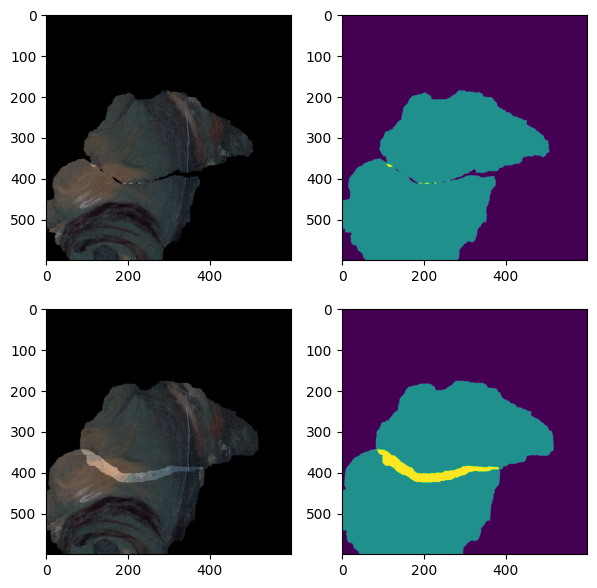

In [139]:
tr = refined_alignment[(l, r)][1]
# tr = Translation(280, -110, -3, 0)
print(tr.confidence)
padded_frag2 = pad_fragment_to_size(frags[r], 200)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], 200), tr.angle), x, y)
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

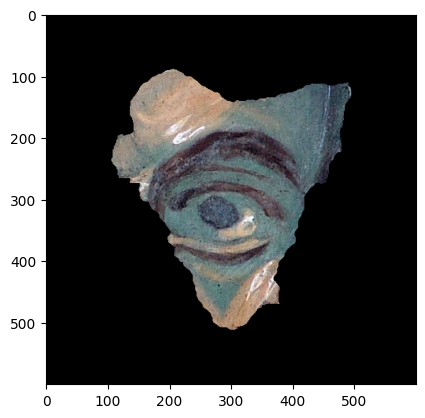

In [111]:
plt.imshow(frags[l].fragment)

In [116]:
np.rad2deg(np.arccos(0.93))

21.56518501524267